In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import csv file
df_mare = pd.read_csv('avaya.csv', encoding="utf_8", low_memory=False)
#concatenate in order to transform into date type
df_mare["start"] = df_mare["Date"] +' '+ df_mare["Start Time"]
df_mare["end"] = df_mare["Date"] +' '+ df_mare["SEGSTOP"]
#drop unecesery lines
df=df_mare.drop(['Call ID','Start Time','SEGSTOP','Time.1','Segment','Date','Calling Party','Dialed Number', 'Split/Skill', 'Trunk','Trunk Group', 'Universal Call ID', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'], axis=1)
#trandform to time format
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df['Time'] = df['Time'].astype(str)
#df['Time'] = df['Time'].str['00']+df['Time'].str[1:]
df['Time'] = '00' + df['Time'].astype(str)
df['Time'] = pd.to_timedelta(df['Time']).astype('timedelta64[s]').astype(int)
df['ora']=df['start'].dt.to_period('H')
df['Day']=df['start'].dt.to_period('D')
df['ora'] = df['ora'].astype(str)
df[['First','interval']] = df.ora.str.split(" ",expand=True,)
#changing the agent code into name
df['ORIGLOGIN'] = df['ORIGLOGIN'].astype(str)
df['ORIGLOGIN'] = df['ORIGLOGIN'].replace(['408003','408010','408006','408005'],['Ag1','Ag2','Ag3','Ag4'])
#drop unecesery lines
df=df.drop(['start', 'end', 'ora','First'], axis=1)
df.columns = ['Duration', 'Agent', 'Day', 'Interval']
#repare the dates
df['Day'] = df['Day'].astype(str)
df['Day'] = df['Day'].replace(['2021-01-02', '2021-02-02', '2021-03-02', '2021-04-02', '2021-05-02', '2021-08-02', '2021-09-02', '2021-10-02', '2021-11-02','2021-12-02'], ['2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11','2021-02-12'])
df['Interval'] = df['Interval'].replace(['10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00','17:00', '09:00', '18:00', '19:00', '20:00', '21:00'], ['10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17','17-18', '09-10', '18-19', '19-20', '20-21', '21-22'])
#make duration into seconds numeric 
df_sec=df_mare.drop(['Call ID','Start Time','SEGSTOP','Segment','ORIGLOGIN','Calling Party','Dialed Number', 'Split/Skill', 'Trunk','Trunk Group', 'Universal Call ID', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17','start','end'], axis=1)
def f(l):
    return [w.replace(':', '00:', 1) if len(w) == 6 and w[0] == ':' else w for w in l]
def fx(l):
    return [x.replace('1:', '01:', 1) if len(x) == 7 and x[0] == '1' else x for x in l]
df_sec['Time']=df_sec.Time.str.split().apply(f).apply(fx).str.join(' ')
df_sec['ora']=df_sec['Time'].str[:2]
df_sec['minute']=df_sec['Time'].str[3:5]
df_sec['secunde']=df_sec['Time'].str[6:]
df_sec['minute'] =df_sec['minute'].apply(pd.to_numeric, errors='coerce')
df_sec['secunde'] = df_sec['secunde'].apply(pd.to_numeric, errors='coerce')
df_sec['ora'] = df_sec['ora'].apply(pd.to_numeric, errors='coerce')
df_sec['final']=df_sec['minute']*60+df_sec['secunde']+df_sec['ora']*3600
df_sec=df_sec.drop(['ora','secunde','minute','Time'], axis=1)
df.head()

,Duration,Agent,Day,Interval
0,2,Ag3,2021-02-01,10-11
1,10,Ag3,2021-02-01,10-11
2,180,Ag3,2021-02-01,10-11
3,64,Ag3,2021-02-01,11-12
4,69,Ag2,2021-02-01,11-12


# The total time spent in call by all 4 agents during February is 59.05 hours 

In [2]:
df['Duration'].sum()/3660

59.053005464480876

# The longest call is 70.2 minutes

In [3]:
df['Duration'].max()/60

70.2

# The *average* call length is **4.04 minutes** (calls under 30s excluded from the analysis)

In [4]:
df[df['Duration'] > 30].mean()/60

Duration    4.037833
dtype: float64

# The *busiest time of the day* is **11:00-12:00** with a total of 261 calls **VARIANTA 1**

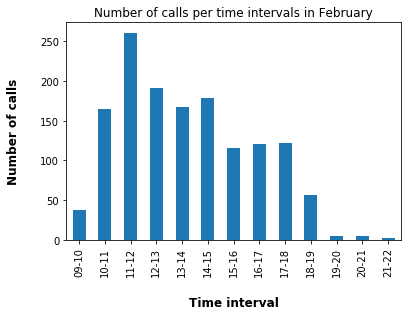

In [5]:
df_hours=df.drop(['Duration'], axis=1) 
df_hours=df_hours.groupby(['Interval', 'Agent']).count()
df_hours.sort_values(by=['Day'], inplace=True,ascending=False)
df_hours.head(3)
df_hours=df.drop(['Duration','Agent'], axis=1) 
df_hours=df_hours.groupby(['Interval']).count()
plt_hours=df_hours.plot(kind="bar")
plt_hours.set_title("Number of calls per time intervals in February",color='black')
plt_hours.get_legend().remove()
plt_hours.set_ylabel("Number of calls", labelpad=20, weight='bold', size=12)
plt_hours.set_xlabel("Time interval", labelpad=20, weight='bold', size=12)
plt_hours

# The *busiest time of the day* is **11:00-12:00** with a total of 261 calls **VARIANTA 2**

Text(0.5, 0, 'Number of calls')

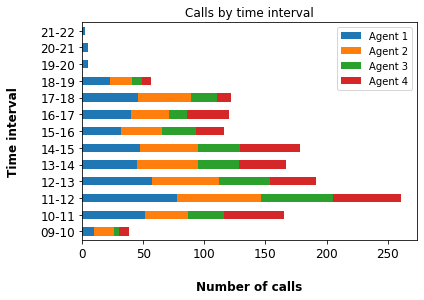

In [6]:
df_hours2=df.drop(['Duration'], axis=1) 
df_hours2=df_hours2.groupby(['Interval', 'Agent']).count()
plt_hours2=df_hours2.groupby(['Interval','Agent']).sum().unstack().plot(kind='barh', stacked=True, title='Calls by time interval', fontsize=12)
plt_hours2.legend(['Agent 1', 'Agent 2', 'Agent 3','Agent 4'],loc='upper right')
plt_hours2.set_ylabel("Time interval", labelpad=20, weight='bold', size=12)
plt_hours2.set_xlabel("Number of calls", labelpad=20, weight='bold', size=12)

# The *busiest day of the week* is **TUESDAY** with a total 362 calls (all Tuesdays in February)

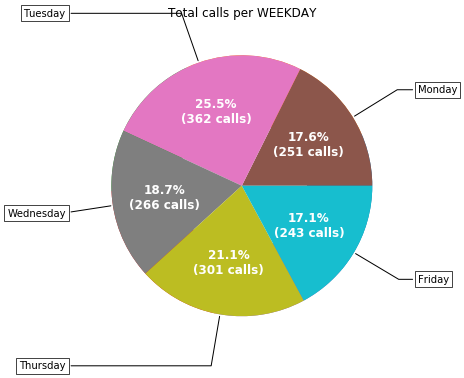

In [11]:
#repare the dates
df_day=df
df_day.Day=df_day.Day.astype(str)
df_day=df_day.replace(to_replace ="2021-02-01", value ="1Monday") 
df_day=df_day.replace(to_replace ="2021-02-02", value ="2Tuesday") 
df_day=df_day.replace(to_replace ="2021-02-03", value ="3Wednesday") 
df_day=df_day.replace(to_replace ="2021-02-04", value ="4Thursday") 
df_day=df_day.replace(to_replace ="2021-02-05", value ="5Friday") 
df_day=df_day.replace(to_replace ="2021-02-08", value ="1Monday") 
df_day=df_day.replace(to_replace ="2021-02-09", value ="2Tuesday") 
df_day=df_day.replace(to_replace ="2021-02-10", value ="3Wednesday") 
df_day=df_day.replace(to_replace ="2021-02-11", value ="4Thursday") 
df_day=df_day.replace(to_replace ="2021-02-12", value ="5Friday") 
df_day=df_day.replace(to_replace ="2021-02-15", value ="1Monday") 
df_day=df_day.replace(to_replace ="2021-02-16", value ="2Tuesday") 
df_day=df_day.replace(to_replace ="2021-02-17", value ="3Wednesday") 
df_day=df_day.replace(to_replace ="2021-02-18", value ="4Thursday") 
df_day=df_day.replace(to_replace ="2021-02-19", value ="5Friday") 
df_day=df_day.replace(to_replace ="2021-02-22", value ="1Monday") 
df_day=df_day.replace(to_replace ="2021-02-23", value ="2Tuesday") 
df_day=df_day.replace(to_replace ="2021-02-24", value ="3Wednesday") 
df_day=df_day.replace(to_replace ="2021-02-25", value ="4Thursday") 
df_day=df_day.replace(to_replace ="2021-02-26", value ="5Friday") 
df_day=df_day.replace(to_replace ="2021-02-27", value ="6Saturday") 
#drop the Saturday outlier
df_day=df_day[~df_day.Day.str.contains("6Saturday")]
#prepare the plot
df_day=df_day.drop(['Interval','Agent'], axis=1) 
df_day=df_day.groupby(['Day']).count()
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))

data =df_day ['Duration']
ingredients = ['Monday','Tuesday','Wednesday','Thursday','Friday' ]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} calls)".format(pct,absolute)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(ingredients[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Total calls per WEEKDAY")
plt.setp(autotexts, size=12, weight="bold")
plt.show()

# One of the *busiest day of the month* was **16 February** with a total of **137 calls**

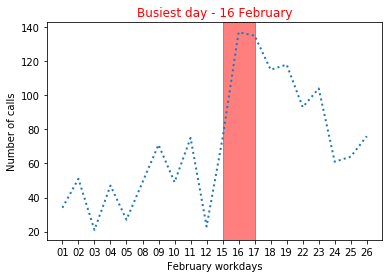

In [12]:
df_b=df
df_b.Day=df_b.Day.astype(str)
df_b=df_b.replace(to_replace ="2021-02-01", value ="01") 
df_b=df_b.replace(to_replace ="2021-02-02", value ="02") 
df_b=df_b.replace(to_replace ="2021-02-03", value ="03") 
df_b=df_b.replace(to_replace ="2021-02-04", value ="04") 
df_b=df_b.replace(to_replace ="2021-02-05", value ="05") 
df_b=df_b.replace(to_replace ="2021-02-08", value ="08") 
df_b=df_b.replace(to_replace ="2021-02-09", value ="09") 
df_b=df_b.replace(to_replace ="2021-02-10", value ="10") 
df_b=df_b.replace(to_replace ="2021-02-11", value ="11") 
df_b=df_b.replace(to_replace ="2021-02-12", value ="12") 
df_b=df_b.replace(to_replace ="2021-02-15", value ="15") 
df_b=df_b.replace(to_replace ="2021-02-16", value ="16") 
df_b=df_b.replace(to_replace ="2021-02-17", value ="17") 
df_b=df_b.replace(to_replace ="2021-02-18", value ="18") 
df_b=df_b.replace(to_replace ="2021-02-19", value ="19") 
df_b=df_b.replace(to_replace ="2021-02-22", value ="22") 
df_b=df_b.replace(to_replace ="2021-02-23", value ="23") 
df_b=df_b.replace(to_replace ="2021-02-24", value ="24") 
df_b=df_b.replace(to_replace ="2021-02-25", value ="25") 
df_b=df_b.replace(to_replace ="2021-02-26", value ="26") 
df_b=df_b.replace(to_replace ="2021-02-27", value ="27") 
#drop the Saturday outlier
df_b=df_b[~df_b.Day.str.contains("27")]
#prepare the plot
df_b=df_b.drop(['Duration','Agent'], axis=1) 
df_b=df_b.groupby(['Day']).count()
df_b
ax=plt.plot(df_b, linestyle = 'dotted',linewidth = '2')
plt.axvspan(10, 12, color='red', alpha=0.5)
plt.title('Busiest day - 16 February',color='red')
plt.xlabel('February workdays')
plt.ylabel('Number of calls')
plt.show()

# Another one of the busiest day of the month was **15 February** with a total of **334 minutes** spent on calls

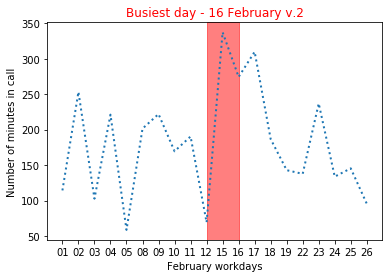

In [15]:
df_b=df
df_b.Day=df_b.Day.astype(str)
df_b=df_b.replace(to_replace ="2021-02-01", value ="01") 
df_b=df_b.replace(to_replace ="2021-02-02", value ="02") 
df_b=df_b.replace(to_replace ="2021-02-03", value ="03") 
df_b=df_b.replace(to_replace ="2021-02-04", value ="04") 
df_b=df_b.replace(to_replace ="2021-02-05", value ="05") 
df_b=df_b.replace(to_replace ="2021-02-08", value ="08") 
df_b=df_b.replace(to_replace ="2021-02-09", value ="09") 
df_b=df_b.replace(to_replace ="2021-02-10", value ="10") 
df_b=df_b.replace(to_replace ="2021-02-11", value ="11") 
df_b=df_b.replace(to_replace ="2021-02-12", value ="12") 
df_b=df_b.replace(to_replace ="2021-02-15", value ="15") 
df_b=df_b.replace(to_replace ="2021-02-16", value ="16") 
df_b=df_b.replace(to_replace ="2021-02-17", value ="17") 
df_b=df_b.replace(to_replace ="2021-02-18", value ="18") 
df_b=df_b.replace(to_replace ="2021-02-19", value ="19") 
df_b=df_b.replace(to_replace ="2021-02-22", value ="22") 
df_b=df_b.replace(to_replace ="2021-02-23", value ="23") 
df_b=df_b.replace(to_replace ="2021-02-24", value ="24") 
df_b=df_b.replace(to_replace ="2021-02-25", value ="25") 
df_b=df_b.replace(to_replace ="2021-02-26", value ="26") 
df_b=df_b.replace(to_replace ="2021-02-27", value ="27")  
#drop the Saturday outlier
df_b=df_b[~df_b.Day.str.contains("27")]
#prepare the plot
df_b=df_b.drop(['Interval','Agent'], axis=1) 
df_b=df_b.groupby(['Day']).sum()/60
df_b
ax=plt.plot(df_b, linestyle = 'dotted',linewidth = '2')
plt.axvspan(9, 11, color='red', alpha=0.5)
plt.title('Busiest day - 16 February v.2',color='red')
plt.xlabel('February workdays')
plt.ylabel('Number of minutes in call')
plt.show()

# Worst day scenario - busiest days intervals gathered into one single day - ***APOCALYPSE***

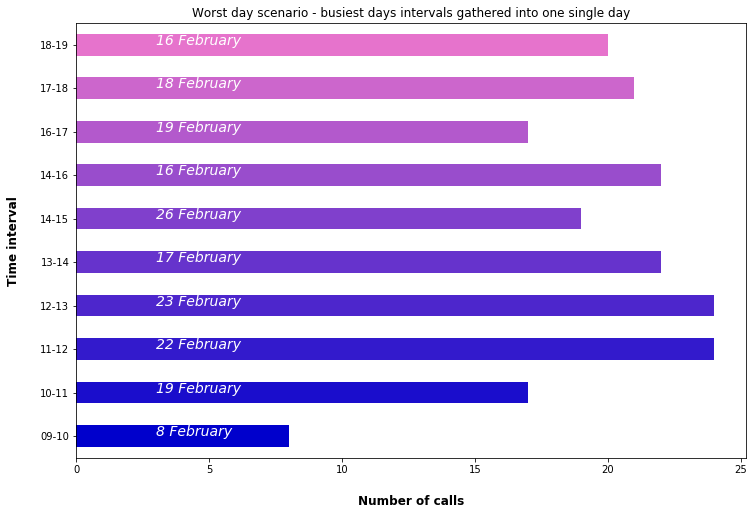

In [10]:
data = {'Interval': ['09-10','10-11','11-12','12-13','13-14','14-15','14-16','16-17','17-18','18-19'],
        'Nr_calls': [8,17,24,24,22,19,22,17,21,20]
       }
  
df1 = pd.DataFrame(data,columns=['Interval','Nr_calls'])
my_colors = [(x/10.0, x/20.0, 0.8) for x in range(len(df1))] # <-- Quick gradient example along the Red/Green dimensions.
ax=df1.plot(x ='Interval', y='Nr_calls', kind = 'barh',figsize=(12,8),color=my_colors)

color=my_colors
ax.text(3, 9, '16 February', style='italic', fontsize=14, Color='white')
ax.text(3, 8, '18 February', style='italic', fontsize=14, Color='white')
ax.text(3, 7, '19 February', style='italic', fontsize=14, Color='white')
ax.text(3, 6, '16 February', style='italic', fontsize=14, Color='white')
ax.text(3, 5, '26 February', style='italic', fontsize=14, Color='white')
ax.text(3, 4, '17 February', style='italic', fontsize=14, Color='white')
ax.text(3, 3, '23 February', style='italic', fontsize=14, Color='white')
ax.text(3, 2, '22 February', style='italic', fontsize=14, Color='white')
ax.text(3, 1, '19 February', style='italic', fontsize=14, Color='white')
ax.text(3, 0, '8 February', style='italic', fontsize=14, Color='white')
ax.set_title("Worst day scenario - busiest days intervals gathered into one single day",color='black')
ax.set_ylabel("Time interval", labelpad=20, weight='bold', size=12)
ax.set_xlabel("Number of calls", labelpad=20, weight='bold', size=12)
ax.get_legend().remove()
ax

# Agents number of calls with specific durations

In [31]:
c1= df['Duration'] > 60 
c2 = df['Duration'] < 600
temp2 = df[c1 & c2]
temp2=temp2.drop(['Day','Duration'], axis=1) 
temp2=temp2.groupby(['Agent']).count()
temp2

,Interval
Agent,
Ag1,157
Ag2,161
Ag3,85
Ag4,109


In [40]:
df_sec['Interval']=df['Interval']
df_sec.head()


,Date,Time.1,final,Interval
0,1/2/2021,10:42:00 AM,2,10-11
1,1/2/2021,10:51:00 AM,10,10-11
2,1/2/2021,10:52:00 AM,180,10-11
3,1/2/2021,11:00:00 AM,64,11-12
4,1/2/2021,11:08:00 AM,69,11-12


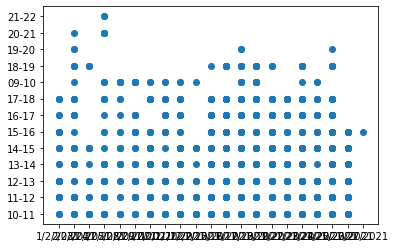

In [42]:
import matplotlib.pyplot as plt
y = df_sec['Interval']
x = df_sec['Date']


plt.scatter(x, y)
plt.show()

In [43]:
grouped = df_sec.groupby('Interval').count()

In [44]:
grouped


,Date,Time.1,final
Interval,,,
09-10,38,38,38
10-11,165,165,165
11-12,261,261,261
12-13,191,191,191
13-14,167,167,167
14-15,178,178,178
15-16,116,116,116
16-17,120,120,120
17-18,122,122,122
